In [25]:
! python -m spacy download en
! pip install wordcloud
! wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/sentiment.tsv?inline=false -O sentiment.tsv

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
--2020-10-12 10:04:22--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/sentiment.tsv?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘sentiment.tsv’

sentiment.tsv           [ <=>                ] 437.05K  --.-KB/s    in 0.1s    

2020-10-12 10:04:23 (3.09 MB/s) - ‘sentiment.tsv’ saved [447540]



# Task: sentiment classification

The task is to classify one-sentence long movie reviews/opinions according to the sentiment they express. There are only two categories: positive and negative sentiment.


> "Data source: [UMICH SI650 - Sentiment Classification](https://www.kaggle.com/c/si650winter11/data)

> Training data: 7086 lines. 
  
> Format: 1|0 (tab) sentence

> Test data: 33052 lines, each contains one sentence. 

> The data was originally collected from opinmind.com (which is no longer active)."

The data is in the file "sentiment.tsv".

# Loading the data

In [26]:
import pandas as pd

df = pd.read_csv('sentiment.tsv', sep='\t', 
                 quoting=3, # Quotes are _never_ field separators
                 header=None)

df.head()

,0,1
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [27]:
df = df[[1,0]] # rearrange columns

df.rename(columns={1:"text", 0:"sentiment"}, inplace=True) # rename columns

df.head()

,text,sentiment
0,The Da Vinci Code book is just awesome.,1
1,this was the first clive cussler i've ever rea...,1
2,i liked the Da Vinci Code a lot.,1
3,i liked the Da Vinci Code a lot.,1
4,I liked the Da Vinci Code but it ultimatly did...,1


# Splitting into train, validation and test

Before doing anything else (!) we divide our data into train, validation and test parts,

In [28]:
# Import the necessary function from Scikit
from sklearn.model_selection import train_test_split
train_test_split(df, test_size=0.1,random_state=13)[1]

,text,sentiment
4840,"by the way, the Da Vinci Code sucked, just let...",0
5810,I think I hate Harry Potter because it outshin...,0
1101,went to see Mission Impossible 3 which is AWES...,1
6916,Brokeback Mountain is fucking horrible..,0
566,The Da Vinci Code is awesome..,1
...,...,...
1997,I love politics and Harry Potter...,1
6770,"Oh, and Brokeback Mountain is a TERRIBLE movie...",0
5150,I hate Harry Potter..,0
167,"I agree with you, I loved Da Vinci Code, I jus...",1


In [29]:
# Import the necessary function from Scikit
from sklearn.model_selection import train_test_split

# Please observe, that we can only do a split into two
# hence our best option is to call the function twice in a chain
# Don't forget to fix the random seed also, eg to 13, since that is a lucky number! :-)
df_train, df_test_valid = train_test_split(df, test_size=0.2,random_state=13)
df_test, df_valid       = train_test_split(df_test_valid, test_size=0.5,random_state=13)

assert len(df_train)==5668 and len(df_valid)==709 and len(df_test)==709
print(len(df_train), len(df_valid), len(df_test))

5668 709 709


In [30]:
train_test_split(df, test_size=0.1,random_state=13)[1]

,text,sentiment
4840,"by the way, the Da Vinci Code sucked, just let...",0
5810,I think I hate Harry Potter because it outshin...,0
1101,went to see Mission Impossible 3 which is AWES...,1
6916,Brokeback Mountain is fucking horrible..,0
566,The Da Vinci Code is awesome..,1
...,...,...
1997,I love politics and Harry Potter...,1
6770,"Oh, and Brokeback Mountain is a TERRIBLE movie...",0
5150,I hate Harry Potter..,0
167,"I agree with you, I loved Da Vinci Code, I jus...",1


# Inspecting the data

In [31]:
df_train.describe()

,sentiment
count,5668.000000
mean,0.559104
std,0.496538
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


We can examine the lengths of sentences as well.

In [32]:
n_chars = df_train.text.apply(lambda x: len(x))

n_chars.describe()

count    5668.000000
mean       60.100565
std        37.931478
min        18.000000
25%        32.000000
50%        48.000000
75%        77.000000
max       203.000000
Name: text, dtype: float64

The first sentence with the maximal length:

In [33]:
long_sentence = df_train.loc[n_chars.idxmax(), "text"]
long_sentence

'A mother in Georgia wants her local school board to take Harry Potter out of the schools and libraries because, in her opinion, reading Harry Potter leads to witchcraft, which according to her is evil...'

# Extra task: Let's do a word cloud!

Let us visualize together and separately (by category) the sentences!

Tool: https://github.com/amueller/word_cloud


Good example: https://github.com/amueller/word_cloud/blob/master/examples/simple.py



In [34]:
# Helper function for displaying a word cloud
# Input: one _UNIFIED_, space separated string!
# Protip: https://www.tutorialspoint.com/python/string_join.
from wordcloud import WordCloud, STOPWORDS
def do_wordcloud(text):
    # Generate a word cloud image
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(text)

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt

    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


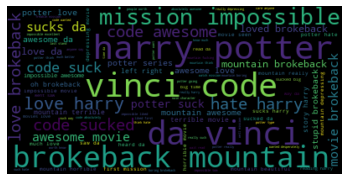

In [35]:
### TASK !!! ####
#Put here the world cloud!
comment_words = '' 
stopwords = set(STOPWORDS)
for val in df.text: 
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
do_wordcloud(comment_words)

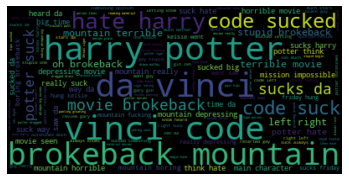

In [36]:
### TASK !!! ####
# Here only the cloud for sentences with negative sentiment!
# Help: the shape of the DataFrame with only the negative sentences is: (2975, 2)
# Source: https://pandas.pydata.org/pandas-docs/stable/indexing.html
comment_words = '' 
stopwords = set(STOPWORDS)
for val in df[df['sentiment'] == 0].text: 
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
do_wordcloud(comment_words)


# Bag of words (BoW) representation of the texts

We will represent each text as a (sparse) vector of lemma (word root) counts for frequent lemmas in the training data. 

For tokenization and lemmatization we use [spaCy](https://spacy.io/), an open source Python NLP library, which can produce a list of unique lemma ids from the text.

In [37]:
import spacy

nlp = spacy.load("en", disable=["parser", "ner"]) 
# We only need the tokenizer, all higher functions are now unnecessary.

spaCy can produce spaCy Doc objects from texts that contain their linguistic analysis, among others lemmas and their unique spaCy string ids.

In [38]:
doc = nlp(long_sentence)
type(doc)

spacy.tokens.doc.Doc

In [39]:
print([token.lemma_ for token in doc ]) # Lemmas

['a', 'mother', 'in', 'Georgia', 'want', '-PRON-', 'local', 'school', 'board', 'to', 'take', 'Harry', 'Potter', 'out', 'of', 'the', 'school', 'and', 'library', 'because', ',', 'in', '-PRON-', 'opinion', ',', 'read', 'Harry', 'Potter', 'lead', 'to', 'witchcraft', ',', 'which', 'accord', 'to', '-PRON-', 'be', 'evil', '...']


In [40]:
print([token.lemma for token in doc]) # Connected unique ID-s

[11901859001352538922, 7963322251145911254, 3002984154512732771, 309210702643012516, 7597692042947428029, 561228191312463089, 16319852998319793599, 13293160603192985325, 14899812206273857344, 3791531372978436496, 6789454535283781228, 5164779919001708464, 2416965663249996073, 1696981056005371314, 886050111519832510, 7425985699627899538, 13293160603192985325, 2283656566040971221, 1785747669126016609, 16950148841647037698, 2593208677638477497, 3002984154512732771, 561228191312463089, 14536103007527724270, 2593208677638477497, 11792590063656742891, 5164779919001708464, 2416965663249996073, 82546335403996757, 3791531372978436496, 17905374590688478165, 2593208677638477497, 7063653163634019529, 701735504652304602, 3791531372978436496, 561228191312463089, 10382539506755952630, 15036397985088571056, 10875615029400813363]


Now we have to convert these lists into BoW vectors. We could "roll our own", but, fortunately, scikit-learn has a feature extractor doing exactly that, the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) so, for the sake of simplicity, we will use that along with spaCy.

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer=lambda s: [token.lemma for token in nlp(s)], #spaCy for analysis
                     min_df= 0.001) # We ignore the lemmas with low document frequency
cv

CountVectorizer(analyzer=<function <lambda> at 0x7f1405cb2488>, binary=False,
                decode_error='strict', dtype=<class 'numpy.int64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                max_features=None, min_df=0.001, ngram_range=(1, 1),
                preprocessor=None, stop_words=None, strip_accents=None,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
                vocabulary=None)

In [42]:
sents = ["I hate this movie.", "The movie is the worst I've seen."]
bows = cv.fit_transform(sents).toarray() 
# A CountVectorizer produces a sparse matrix, we convert to ndarray
bows

array([[1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 2, 0, 1, 1, 1, 1, 1, 1]])

Using the CountVectorizer we convert the text columns of our train, validation and  test data into three sparse matrices.

In [43]:
bows_train = cv.fit_transform(df_train.text)
bows_train.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bow_length = bows_train.shape[1]
print("BoW length:", bow_length)
bows_train

BoW length: 374


<5668x374 sparse matrix of type '<class 'numpy.int64'>'
	with 63241 stored elements in Compressed Sparse Row format>

In [44]:
bows_valid = cv.transform(df_valid.text)
bows_valid.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement
bows_test = cv.transform(df_test.text)
bows_test.sort_indices() # comes from TF2.0 sparse implementation, obscure requirement

# Task: The model

We build a feed-forward neural network in Keras for our binary classification task, which will be trained with cross-entropy loss and minibatch SGD.

In [45]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD


# USE KERAS FUNKTIONAl API!


# Parameters
############

hidden_size = 100

# Model
#######
# Define (instantiate) the input layer!
# Give the shape parameter the length of a BoW vector as length
# WARNING: shape only accepts a tuple, even is one dimensional!
# Input layer
inputs = Input((bow_length,))

# Hidden layer
##############
# Define a fully connected hidden layer that can be modified by the parameters above!
# Use the ReLU activation function
# Give the inputs to the hidden layer
# Please be aware, that in Keras Functional, the parameters defining the layer are 
# "instantiation" parameters, but the input of the layer is already a "call" parameter!
# (The magic lies in the brackets... ;-)

hidden_output = Dense(units=hidden_size, activation = 'relu')(inputs)

# Softmax 
#########
# Define the output softmax
# (Which is a fully connected layer with activation accordingly...)
# Please remember, we have exactly two classes! 
# (We choose to use this generalized, Softmax approach...)
# We feed the layer with the output of the hidden one.

predictions =  Dense(units=2,activation = 'softmax')(hidden_output)

# Whole model
##############
# Nothing more is left, than to instantiate the model
# Please ensure input and output is right!

model = Model(inputs,predictions)

# Optimization
##############
# For now, we stick to this.
optimizer = SGD(lr=0.01)
 

# Compilation and teaching
##########################

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', # use this cross entropy variant
                                                      # since the input is not one-hot encoded
              metrics=['accuracy']) #We measure and print accuracy during training
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 374)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               37500     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 37,702
Trainable params: 37,702
Non-trainable params: 0
_________________________________________________________________


# Training

## Let's train the model on GPU
- List the devices and put it in training with GPU
- Manage the session to run

In [46]:
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib
import tensorflow as tf
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2908284386185590696
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16621486255508903760
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8299494628277493626
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15689635648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6636717995422126462
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [47]:
with tf.device('/gpu:0'):
    model.fit(x=bows_train, 
            y=df_train.sentiment.values,
            validation_data=(bows_valid, df_valid.sentiment.values),
            epochs=50,
            batch_size=200)

# Please don't just run, understand!

Epoch 1/50
29/29 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.6253 - val_loss: 0.6606 - val_accuracy: 0.6728
Epoch 2/50
29/29 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6861 - val_loss: 0.6240 - val_accuracy: 0.7278
Epoch 3/50
29/29 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.7292 - val_loss: 0.5948 - val_accuracy: 0.7898
Epoch 4/50
29/29 [==============================] - 0s 3ms/step - loss: 0.5861 - accuracy: 0.7788 - val_loss: 0.5681 - val_accuracy: 0.8237
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5608 - accuracy: 0.8072 - val_loss: 0.5431 - val_accuracy: 0.8449
Epoch 6/50
29/29 [==============================] - 0s 3ms/step - loss: 0.5366 - accuracy: 0.8497 - val_loss: 0.5196 - val_accuracy: 0.8843
Epoch 7/50
29/29 [==============================] - 0s 3ms/step - loss: 0.5132 - accuracy: 0.8689 - val_loss: 0.4970 - val_accuracy: 0.8858
Epoch 8/50
29/29 [==

# Prediction

In [49]:
print("=== INTERACTIVE DEMO ===")
while True:
    s = input("Enter a short text to evaluate or press return to quit: ")
    if s == "":
        break
    else:
        bow = cv.transform([s])
        prob_pred = model.predict(bow[0])
        print(f"Positive vs negative sentiment probability: {prob_pred[0,1]} vs {prob_pred[0,0]}")

=== INTERACTIVE DEMO ===
Enter a short text to evaluate or press return to quit: "Professor Florian is the best" 
Positive vs negative sentiment probability: 0.7569841742515564 vs 0.2430158257484436
Enter a short text to evaluate or press return to quit: 
